In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import eigh
from scipy.interpolate import UnivariateSpline
from scipy.signal import find_peaks
from scipy.integrate import simps

from collections import Counter
from itertools import product
from collections import namedtuple

from multiprocessing import Pool
from tqdm.notebook import tqdm

import cvxpy as cp

# Loading and pre-processing pulses

Load pulses. Note that each pulse has its own time axis

In [2]:
%ls "experimental data 01-07-2022"

PPLN_f05_400uJ_xavg.txt  PPLN_f07_400uJ_xavg.txt  PPLN_f09_400uJ_xavg.txt
PPLN_f06_400uJ_xavg.txt  PPLN_f08_400uJ_xavg.txt


In [3]:
pulses = {}

# declare type
Pulse = namedtuple('Pulse', ['time', 'field', 'interp_field', 'peaks_time', 'half_period'])

# save index where the field reseaches its maximum
peak_position = {}

for freq in range(5, 10):
    data = np.loadtxt(
        'experimental data 01-07-2022/PPLN_f0{}_400uJ_xavg.txt'.format(freq)
    )
    time, field = data.T
    
    # check that time is time
    assert np.all(np.diff(time) > 0), "`time` is probably not time"
    
    label = '0.{} THz'.format(freq)
    
    # Relabel time axis such that peak field is at zero time 
    abs_field = np.abs(field)
    indx = abs_field.argmax()
    peak_position[label] = indx
    #time -= time[indx] 
    
    
    # Extract information for the combinatorial method 
    peaks_time = time[find_peaks(abs_field, height=0.6 * abs_field.max())[0]]
    half_period = Counter(np.diff(peaks_time)).most_common(1)[0][0]
    
    
    # Saving the data 
    pulses[label] = Pulse(
        time, 
        field, 
        UnivariateSpline(time, field, ext='zeros', s=0),
        peaks_time,
        half_period,
    )
    
    

# saving the largest frequency
largest_freq = label

In [4]:
peak_position

{'0.5 THz': 900,
 '0.6 THz': 245,
 '0.7 THz': 545,
 '0.8 THz': 343,
 '0.9 THz': 169}

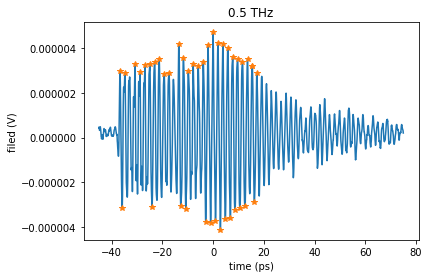

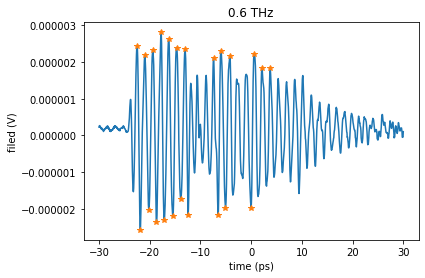

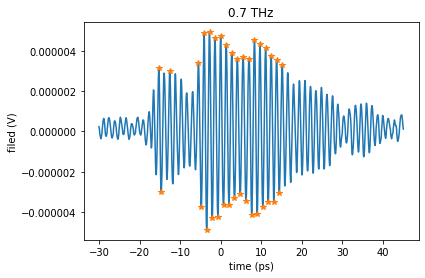

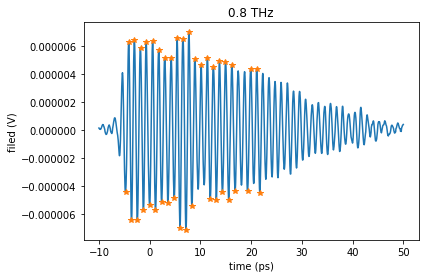

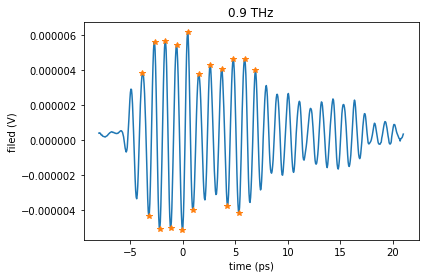

In [5]:
# Plot pulses
for freq, data in pulses.items():
    plt.title(freq)
    plt.plot(data.time, data.field)
    plt.plot(data.peaks_time, data.field[np.searchsorted(data.time, data.peaks_time)], '*')
    plt.xlabel('time (ps)')
    plt.ylabel('filed (V)')
    plt.show()  
    

### Manually extract observational time window 

0.5499999999999998


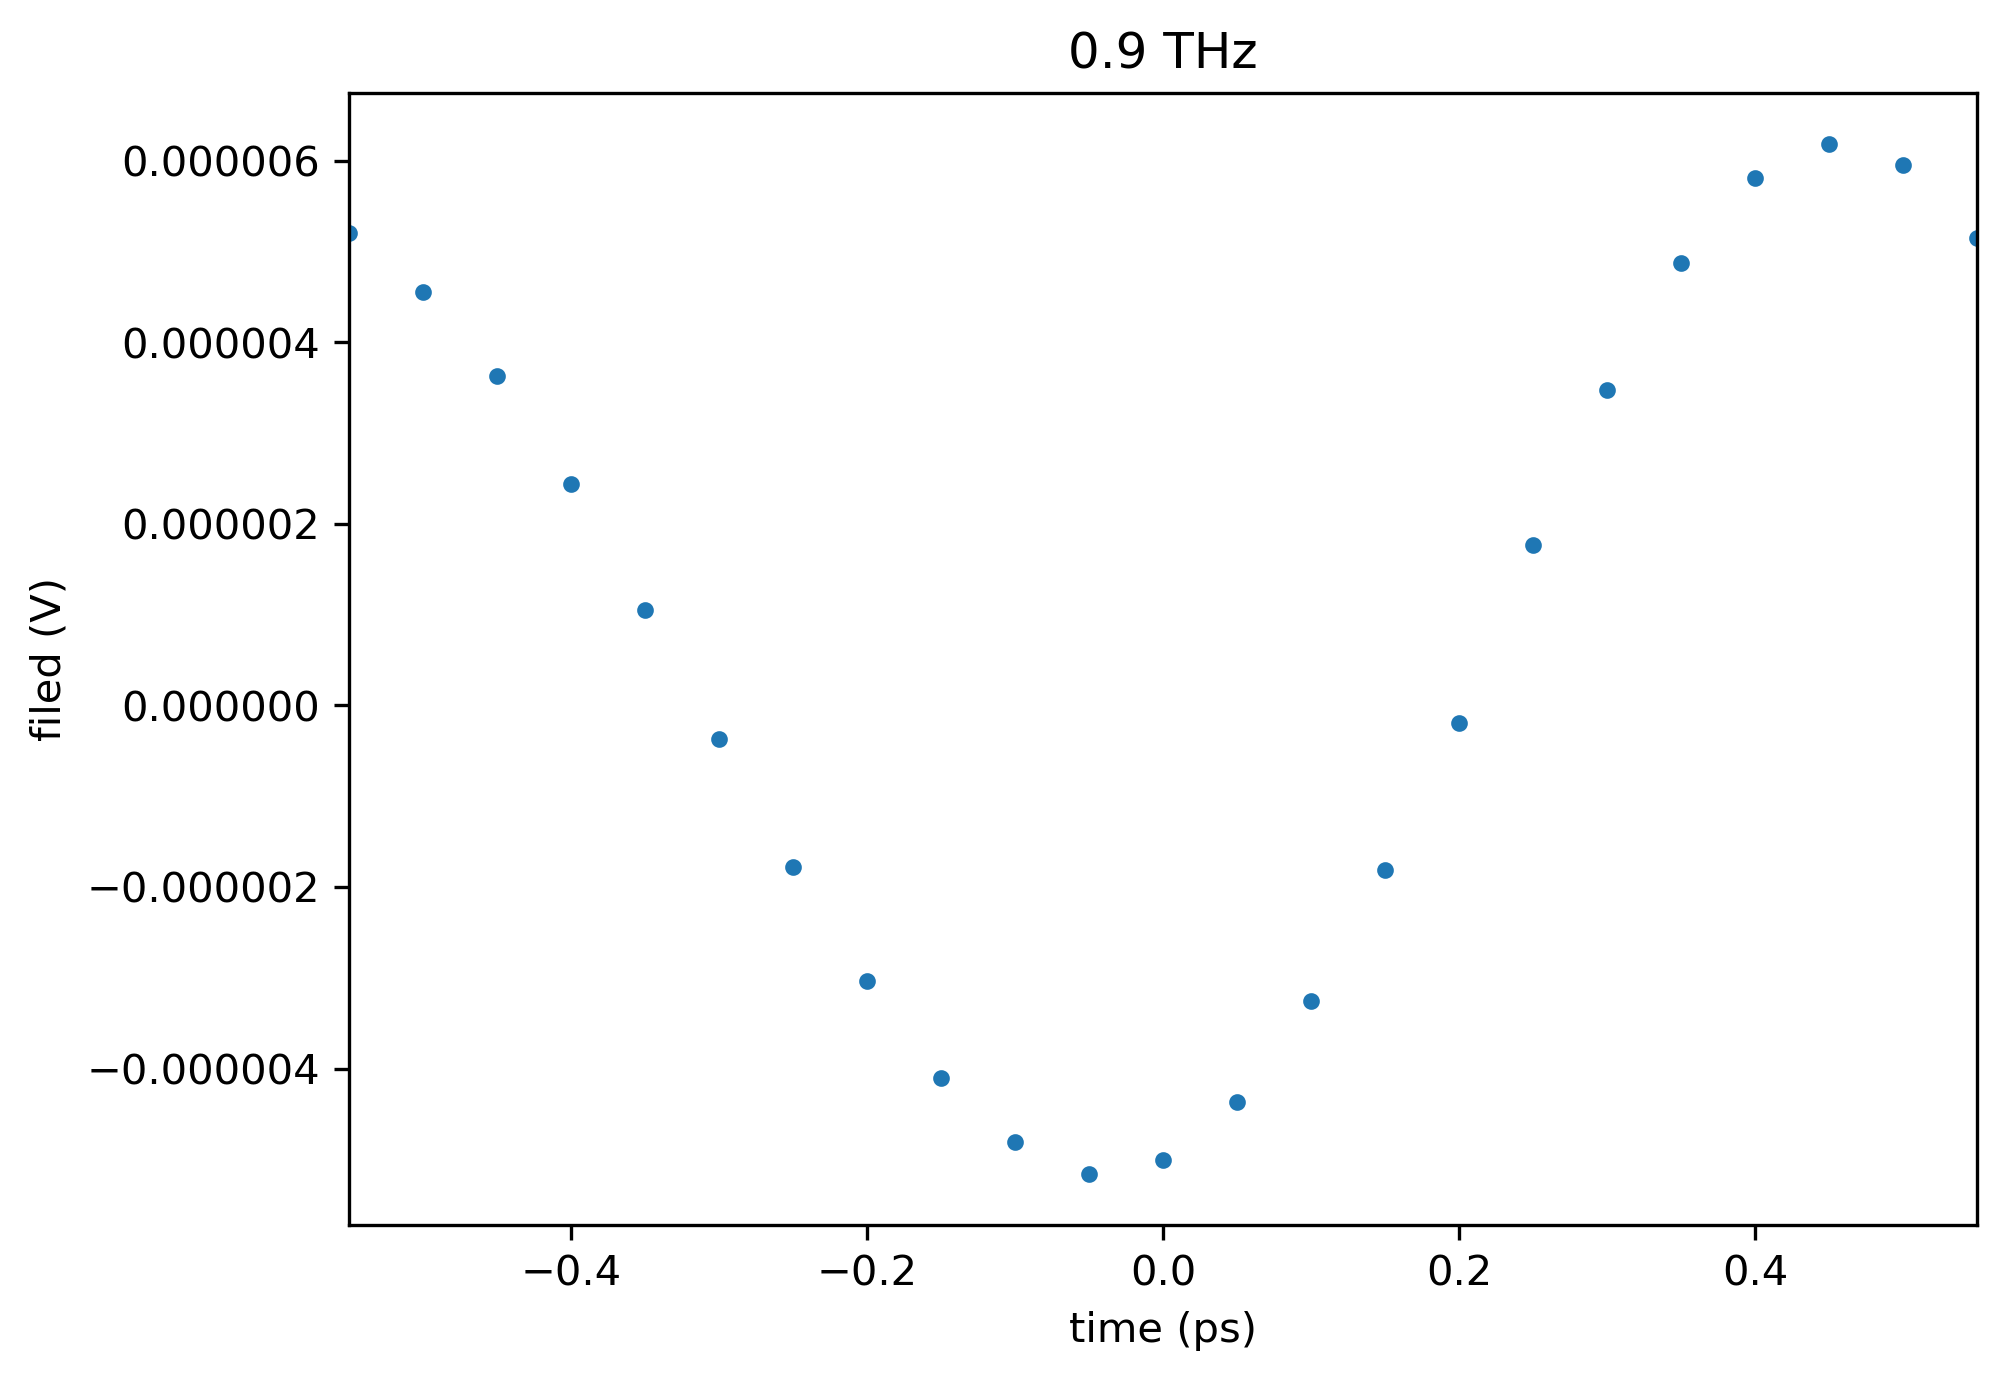

In [6]:
plt.figure(figsize=(7, 5), dpi=300)
    
time = pulses[largest_freq].time
field = pulses[largest_freq].field
half_period = pulses[largest_freq].half_period

print(half_period)

plt.plot(time, field, '.')

#indx = peak_position[largest_freq]
indx = 200

observational_window = -half_period, half_period
#observational_window = time[indx - 14], time[indx + 12]

plt.xlim(observational_window)
plt.xlabel('time (ps)')
plt.ylabel('filed (V)')
plt.title(largest_freq)    
plt.show()

### Plot all pulses within the observational window

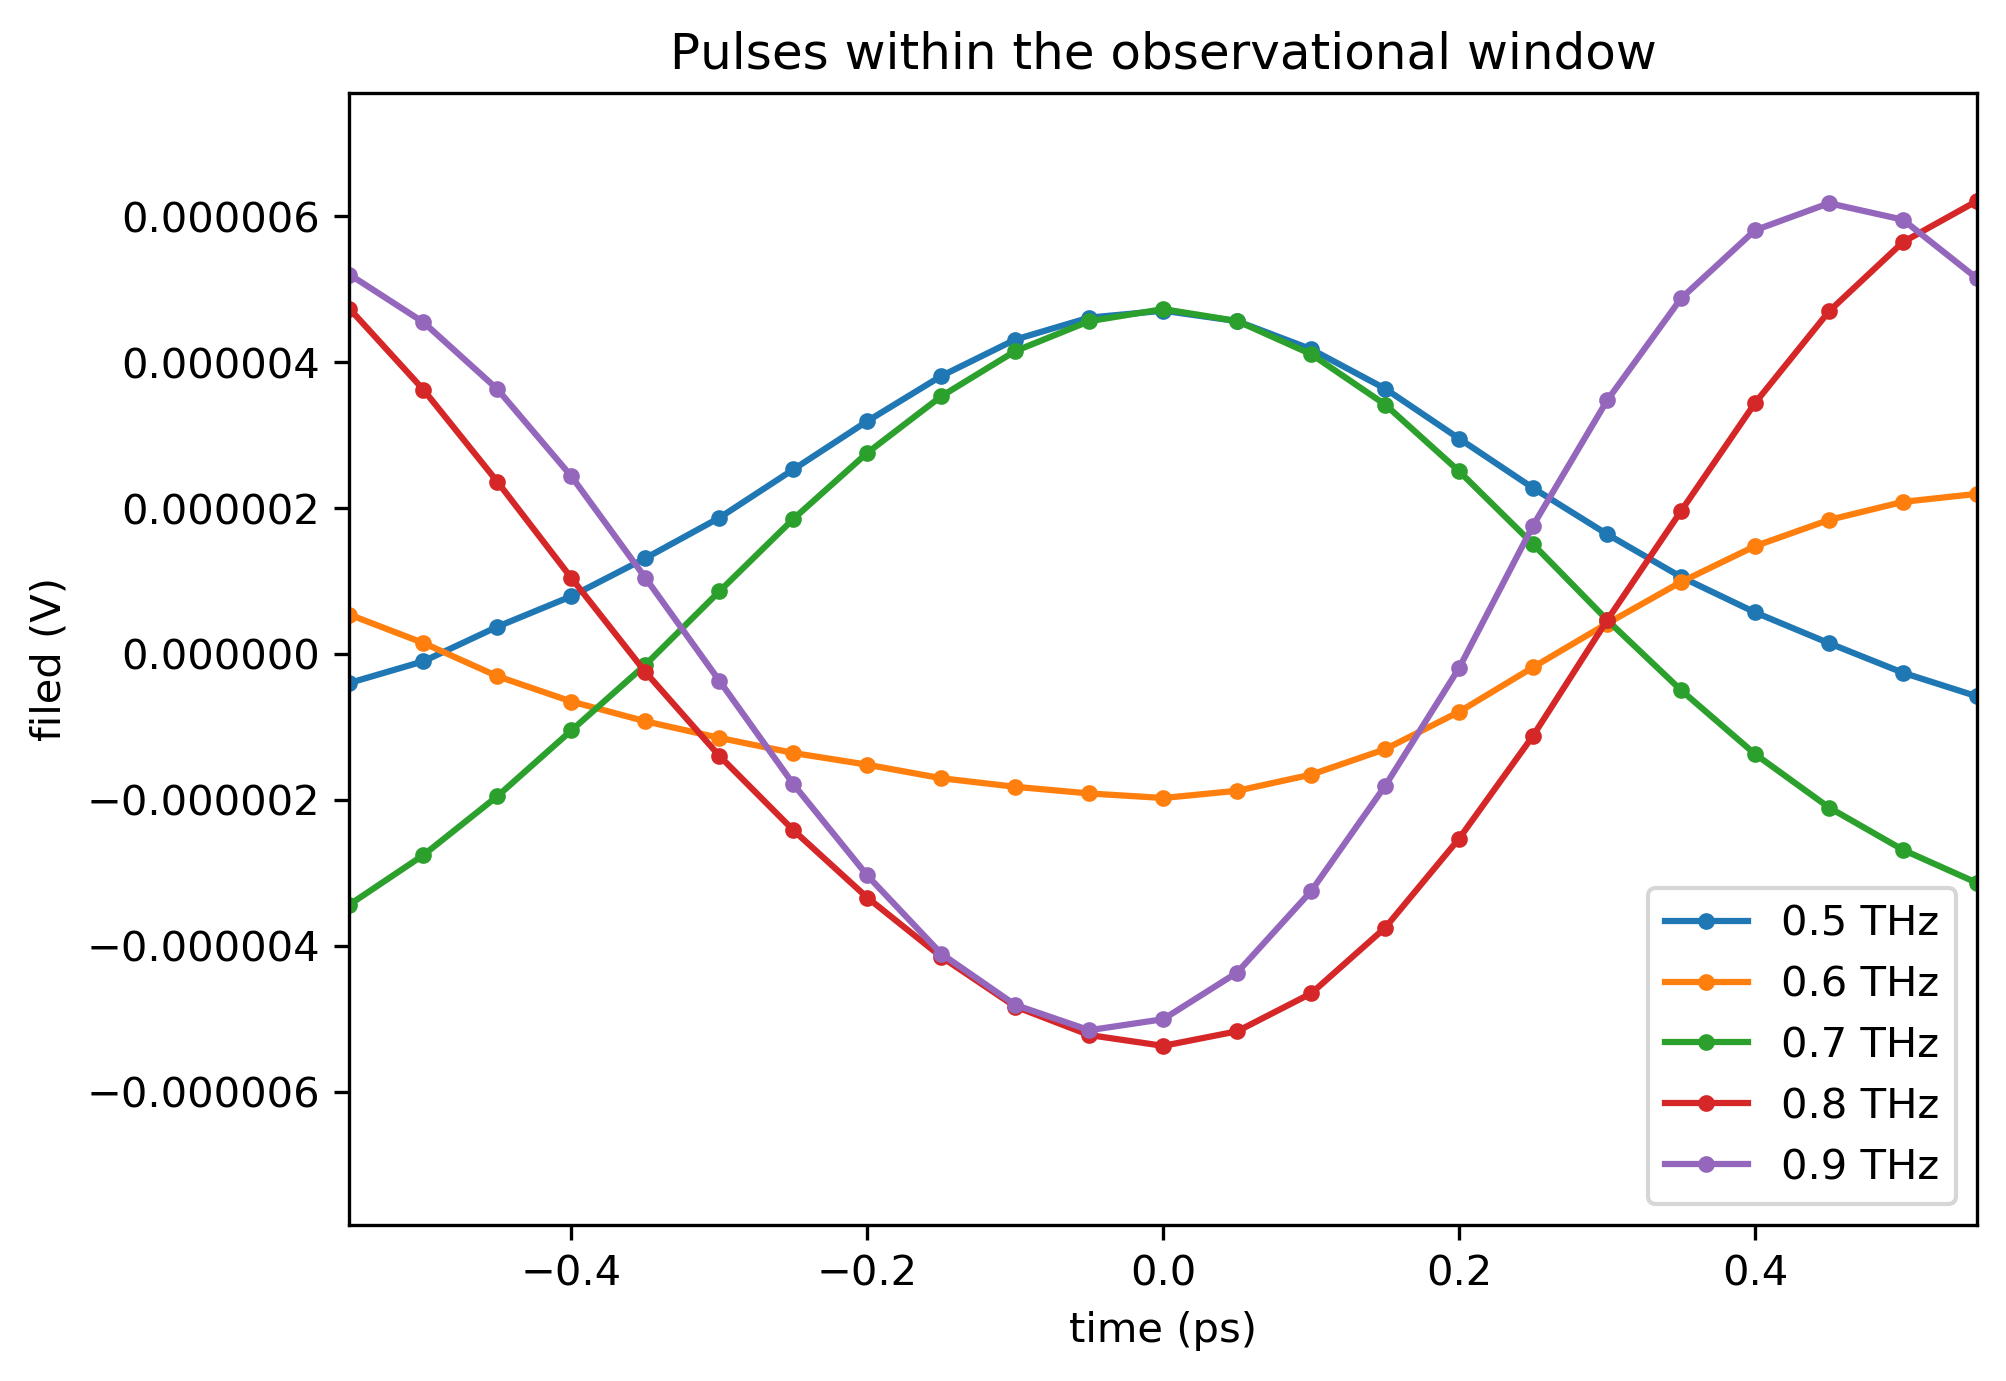

In [7]:
# Plot pulses
plt.figure(figsize=(7, 5), dpi=300)

plt.title("Pulses within the observational window")

for freq, data in pulses.items():
    plt.plot(data.time, data.field, '.-', label=freq)
    
    plt.xlim(np.array(observational_window))
    plt.xlabel('time (ps)')
    plt.ylabel('filed (V)')

plt.legend()
plt.show()  

# Synthesizing superoscillations 

The first step, Calculate the overlap matrix
$$
 S_{ij}(t_1, t_2) = \int_{t_1}^{t_2} E_i(t) E_j(t) dt
$$

In [8]:
def get_overlap(pulse1, pulse2, int_bounds):
    
    # common time axis
    t = np.union1d(pulse1.time, pulse2.time)
    
    return UnivariateSpline(
        t, 
        pulse1.interp_field(t) * pulse2.interp_field(t), 
        ext='zeros', 
        s=0
    ).integral(*int_bounds)

Get $S_{ij}(-\infty, \infty)$

In [9]:
S_infty = [
    [
        get_overlap(pulse1, pulse2, (-np.inf, np.inf)) 
        for pulse2 in pulses.values()
    ] for pulse1 in pulses.values()
]

S_infty = np.array(S_infty)

assert np.allclose(S_infty, S_infty.T)

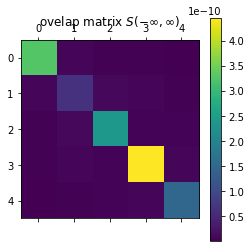

In [10]:
plt.matshow(np.abs(S_infty))
plt.colorbar()
plt.title("ovelap matrix $S(-\infty, \infty)$")
plt.show()

Get overlap matrix for the observational window

In [11]:
S_observ = [
    [
        get_overlap(pulse1, pulse2, observational_window) 
        for pulse2 in pulses.values()
    ] for pulse1 in pulses.values()
]

S_observ = np.array(S_observ)

assert np.allclose(S_observ, S_observ.T)

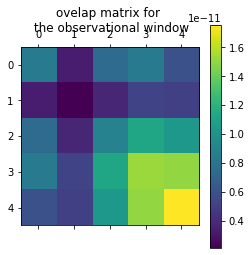

In [12]:
plt.matshow(np.abs(S_observ))
plt.colorbar()
plt.title("ovelap matrix for \n the observational window")
plt.show()

### Finding optimal strategies for generating supperoscilations via eigenvectors

In [13]:
vals, vecs = eigh(S_observ) #, S_infty)

# Ploting superoscilations

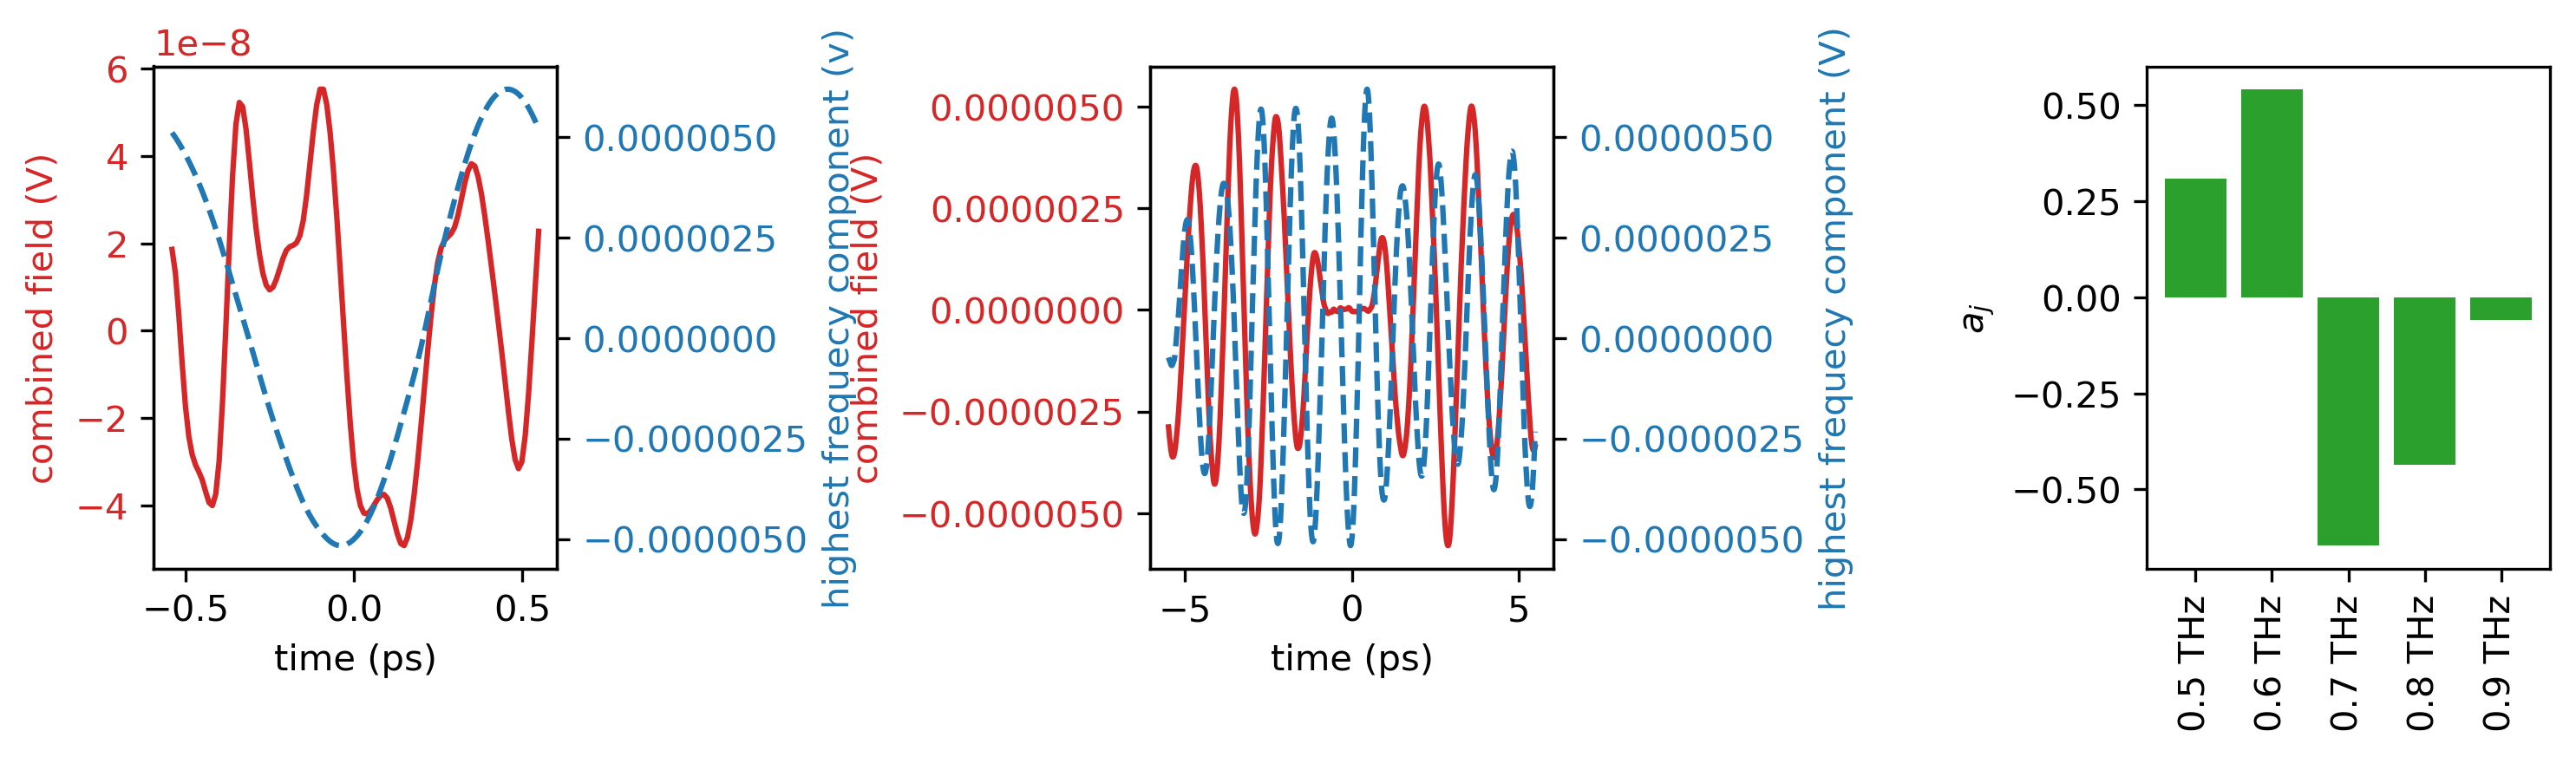

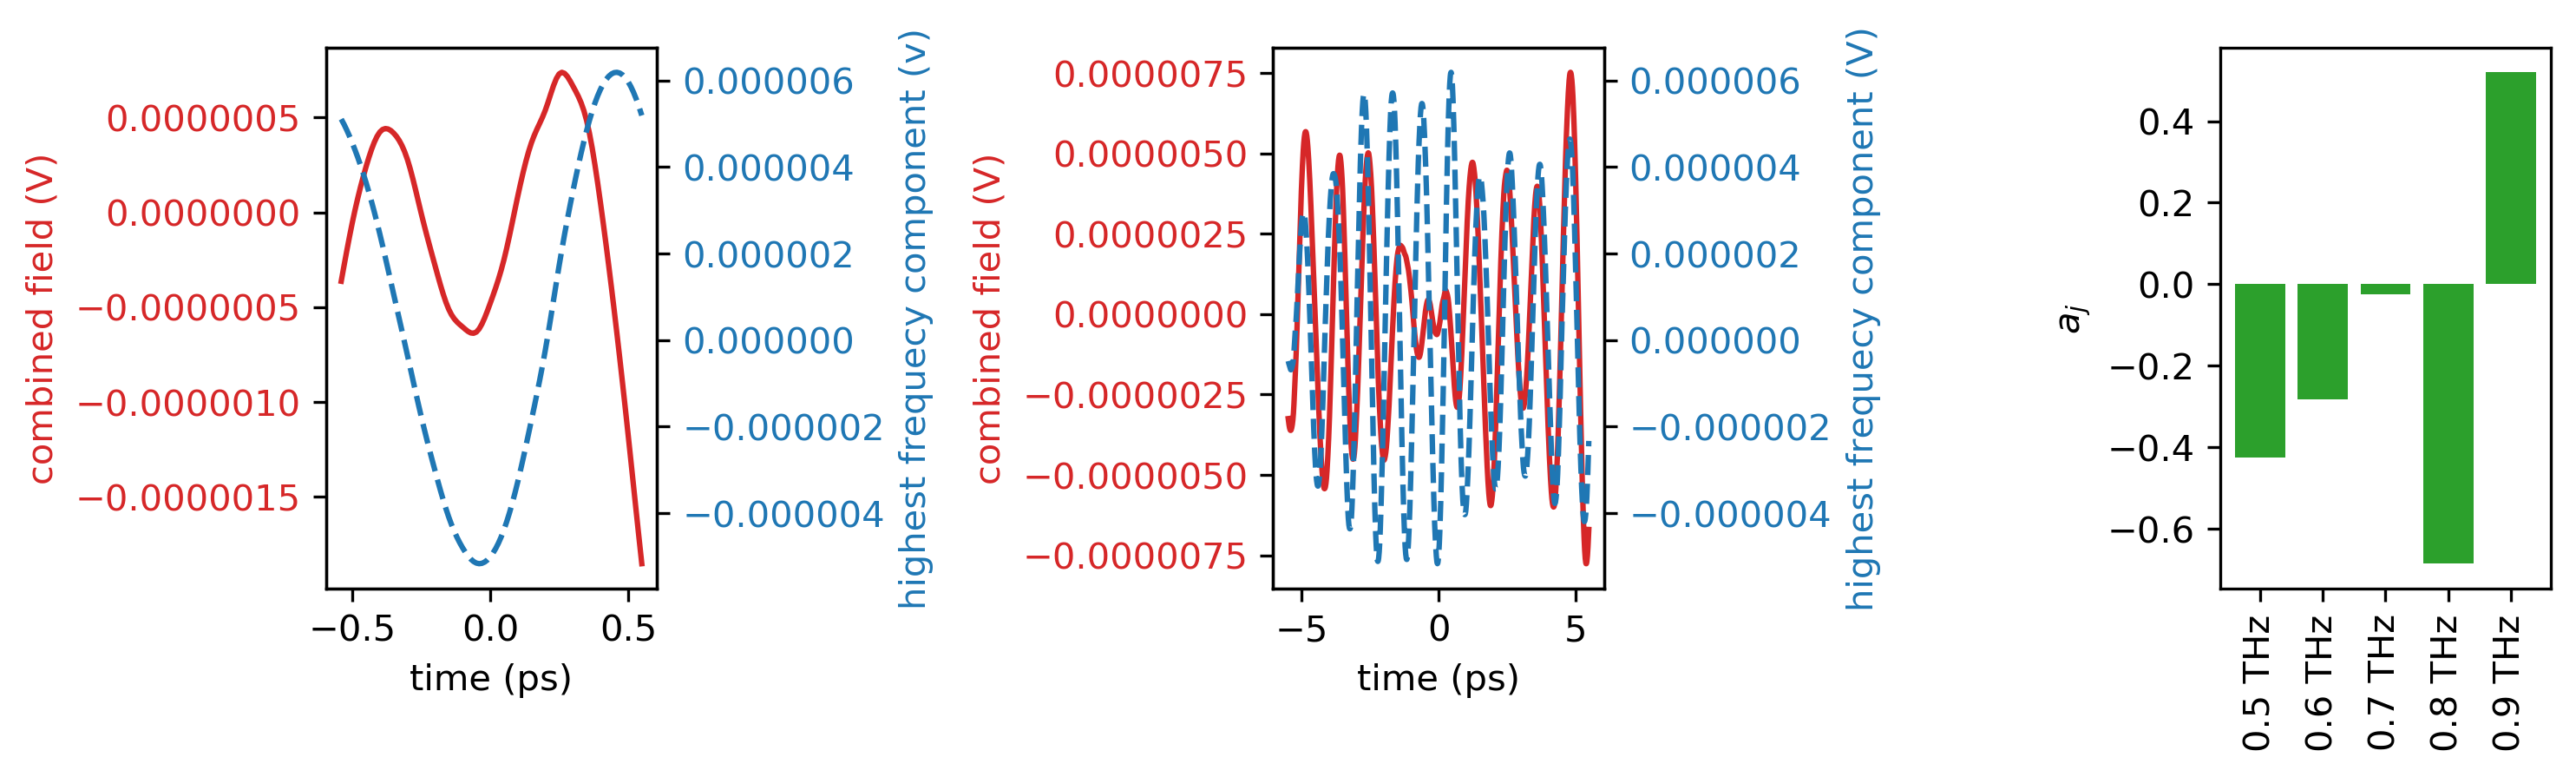

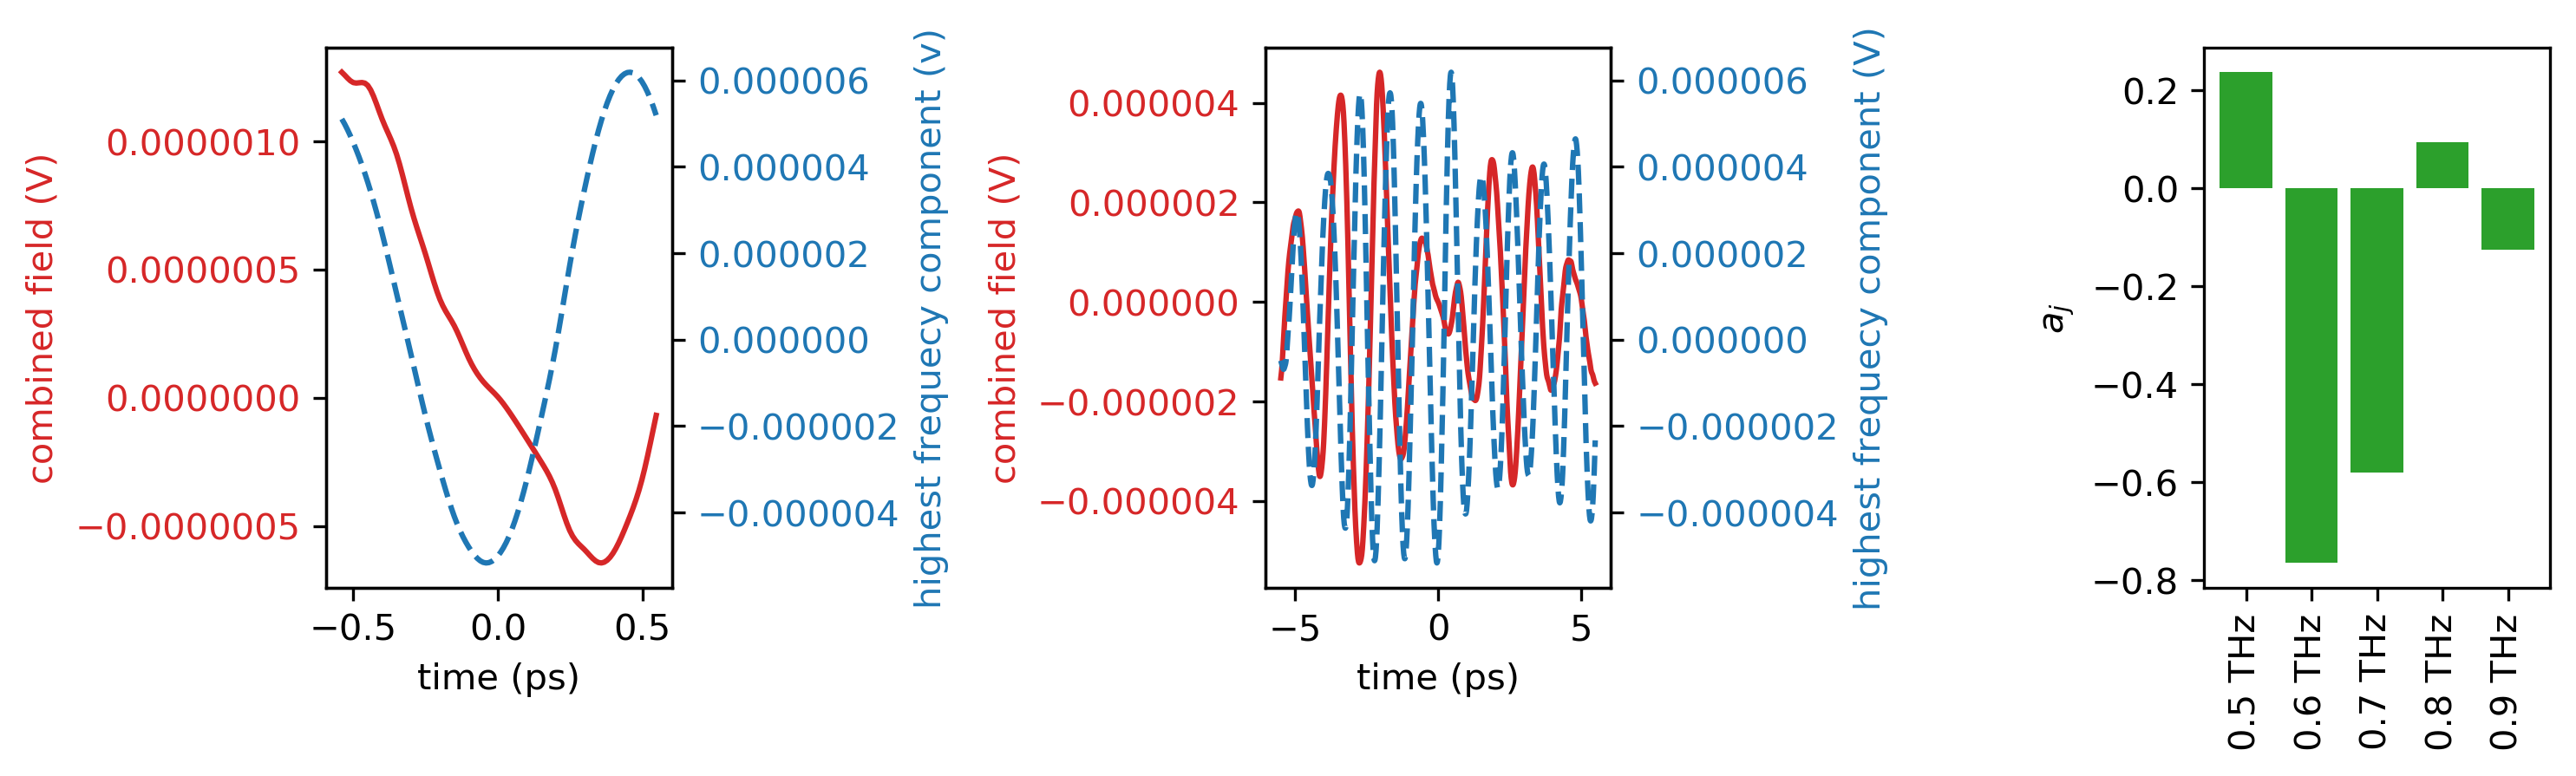

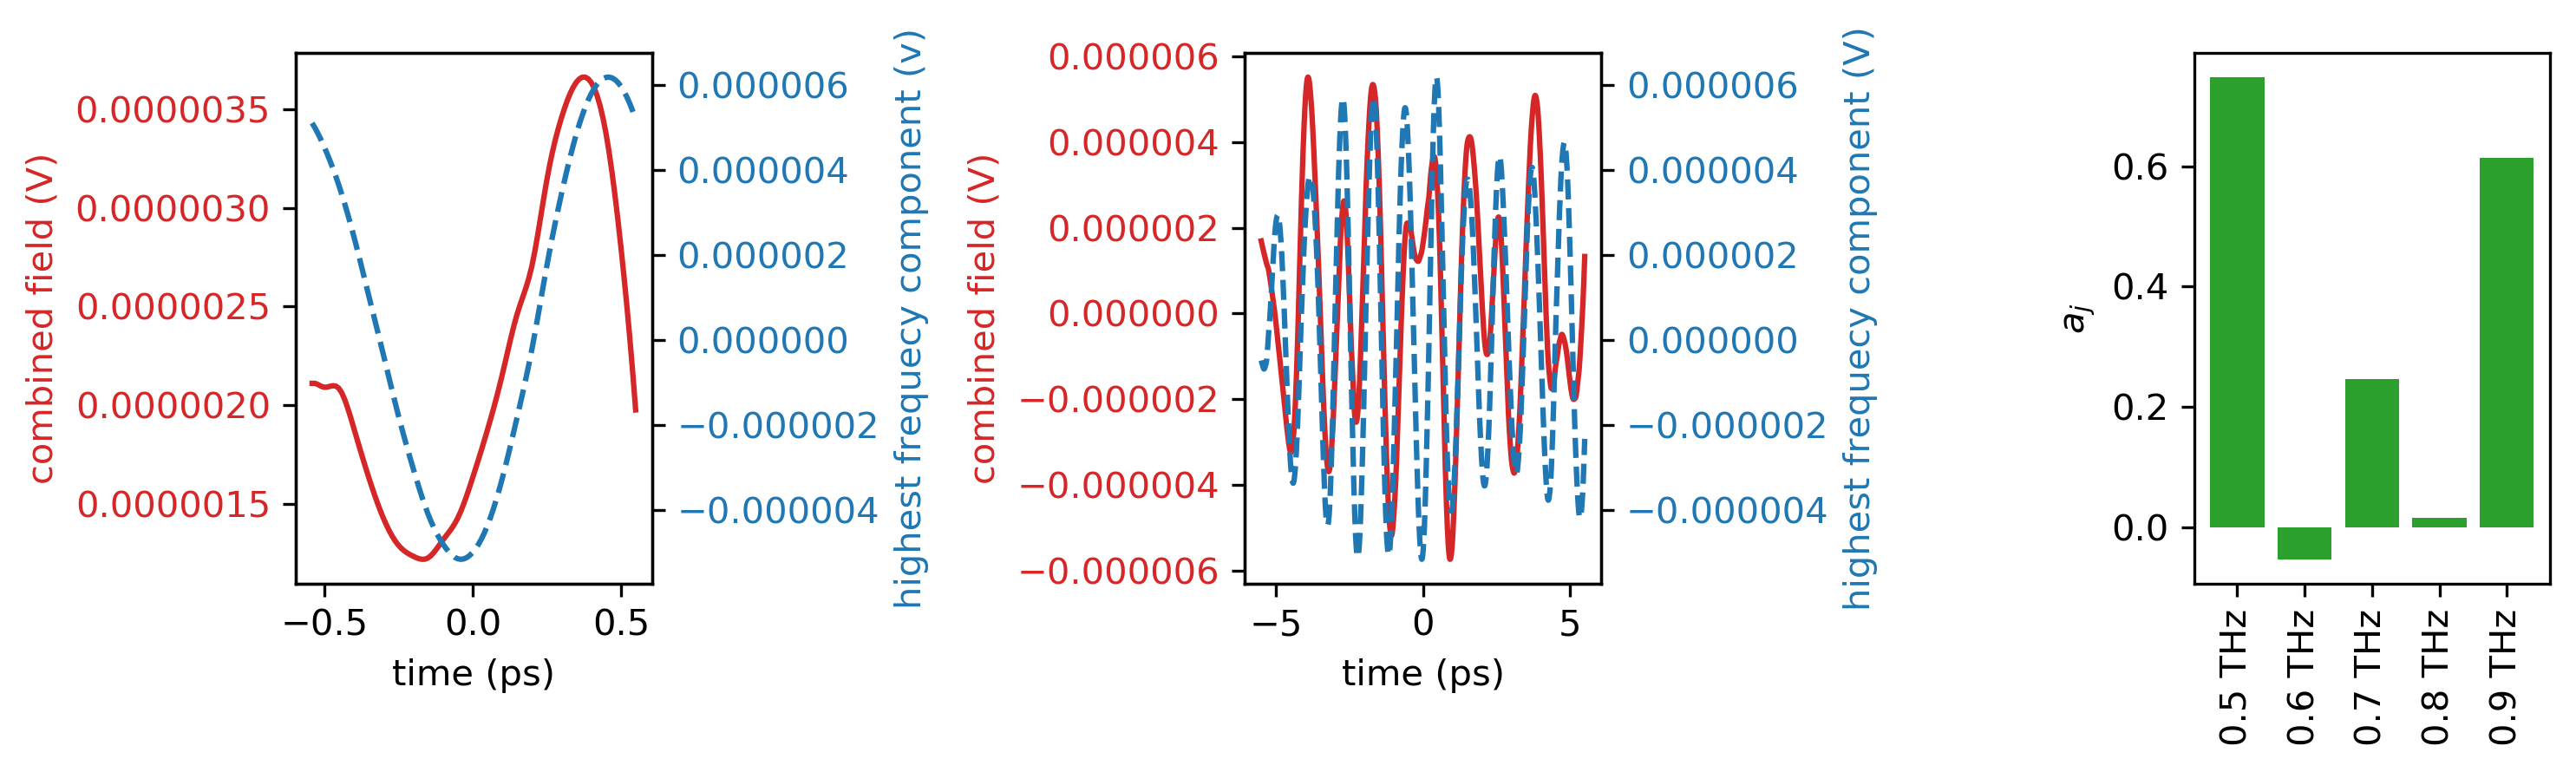

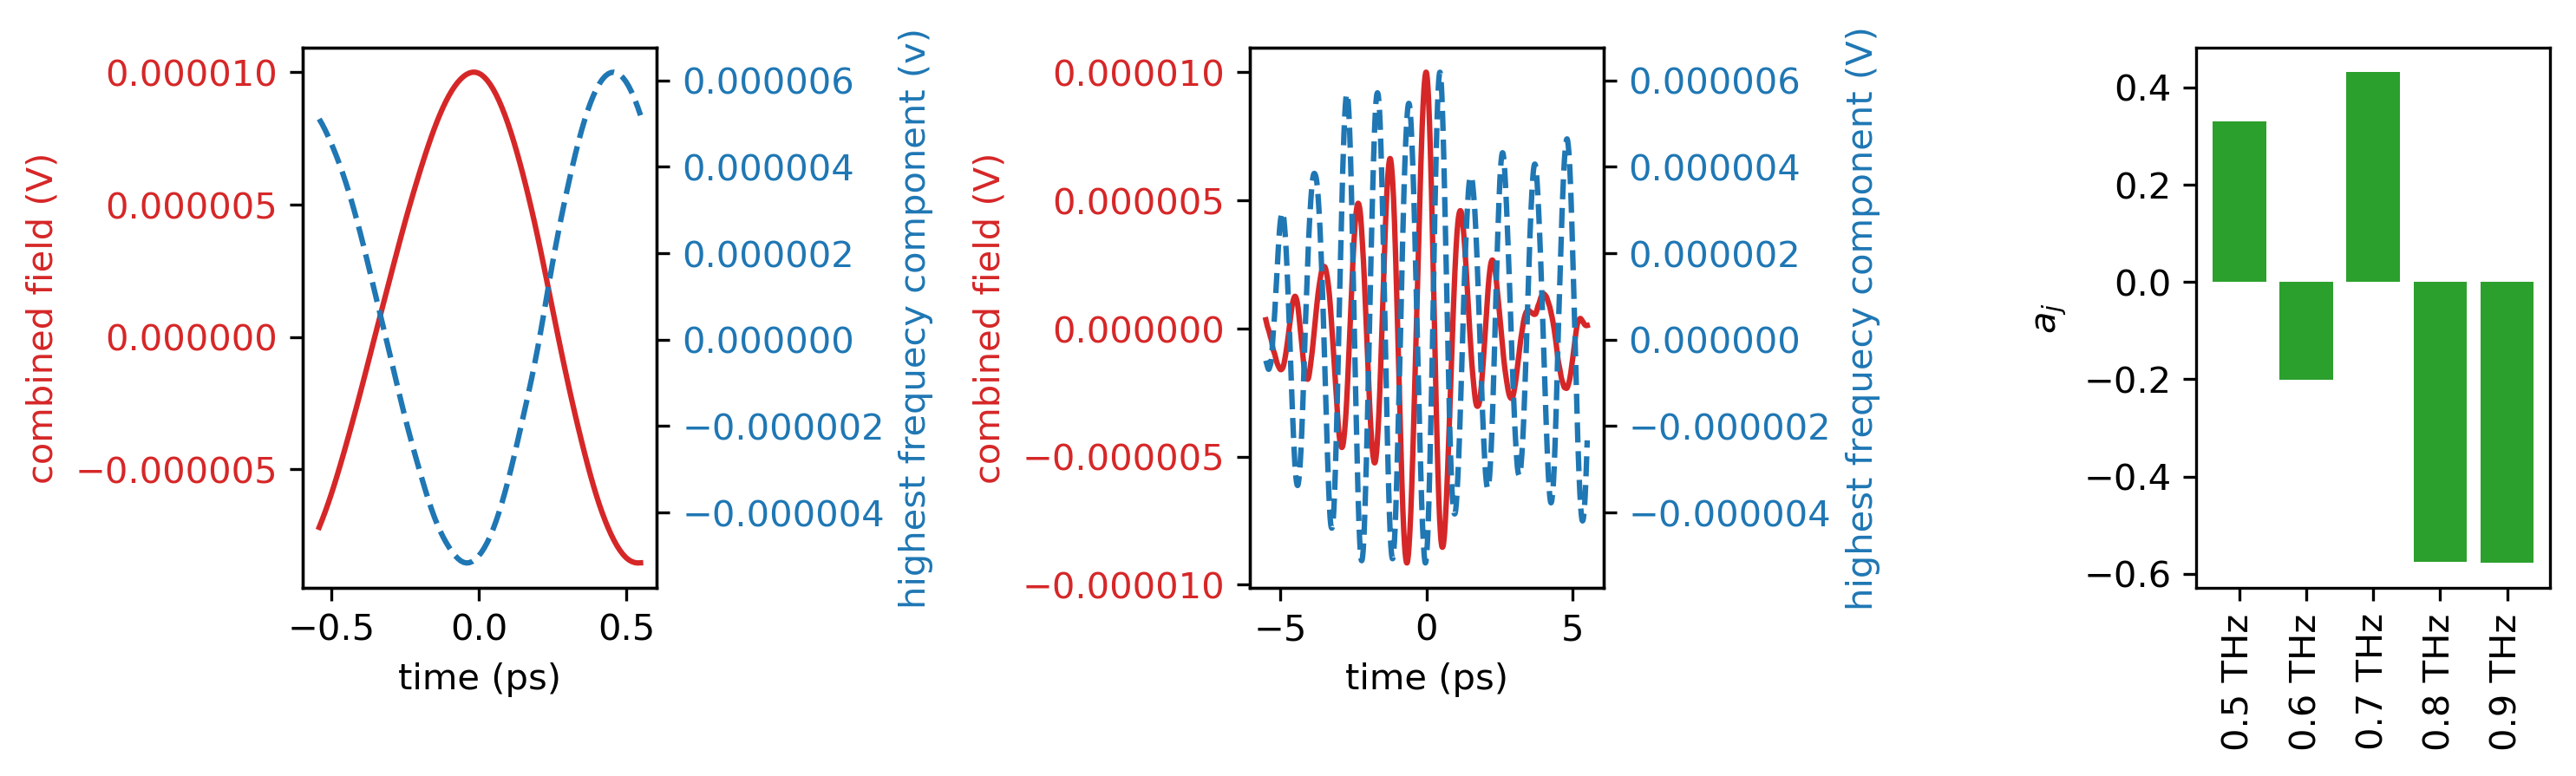

In [14]:
# Use refined time axis for the largest frequency component
fastest = pulses[largest_freq]
t = fastest.time
t = np.linspace(t.min(), t.max(), 5 * t.size)

# extract indices of the observational window
ow1 = np.searchsorted(t, observational_window[0], side='left')
ow2 = np.searchsorted(t, observational_window[1], side='right')

# extract indices of the larger window
Lw1 = np.searchsorted(t, 10 * observational_window[0], side='left')
Lw2 = np.searchsorted(t, 10 * observational_window[1], side='right')

for num, eig_vector in enumerate(vecs.T):
    
    # a sanity check
    #assert np.allclose(eig_vector.T @ S_infty @ eig_vector, 1.)
    
    # Normalizing amplitudes
    #eig_vector = eig_vector / np.abs(eig_vector).max()
    
    # get superoscilating field
    field = sum(
        c * _.interp_field(t) for c, _ in zip(eig_vector, pulses.values())
    )
    
    # plot zoom in view
    fig, (ax1, ax1_, ax1__) = plt.subplots(1, 3, figsize=(10, 3), dpi=300)
    
    t_ow = t[ow1:ow2]
    
    color1 = 'tab:red'
    ax1.set_ylabel('combined field (V)', color=color1)
    ax1.plot(t_ow, field[ow1:ow2], color=color1)
    #ax1.plot(t_ow, combined_pulse.interp_field(t_ow) / 10, color='black')
    ax1.tick_params(axis='y', labelcolor=color1)
    
    ax1.set_xlabel('time (ps)')
    
    ax2 = ax1.twinx() 
    
    color2 = 'tab:blue'
    ax2.set_ylabel('highest frequecy component (v)', color=color2)
    ax2.plot(t_ow, fastest.interp_field(t_ow), '--', color=color2)
    #ax2.plot(fastest.time, fastest.field, '*')
    #ax2.set_xlim(observational_window)
    ax2.tick_params(axis='y', labelcolor=color2)
    
    
    # plot zoom out view
    
    ax1 = ax1_
    
    t_lw = t[Lw1:Lw2]
    
    ax1.set_ylabel('combined field (V)', color=color1)
    ax1.plot(t_lw, field[Lw1:Lw2], color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    
    #ax1.plot(t_lw, combined_pulse.interp_field(t_lw), color='black')
    
    ax1.set_xlabel('time (ps)')
    
    ax2 = ax1.twinx() 
    
    ax2.set_ylabel('highest frequecy component (V)', color=color2)
    ax2.plot(t_lw, fastest.interp_field(t_lw), '--', color=color2)
    #ax2.plot(fastest.time, fastest.field, '*')
    #ax2.set_xlim(10 * np.array(observational_window))
    ax2.tick_params(axis='y', labelcolor=color2)
    
    # plot pulses
    ax1 = ax1__
    
    ax1.bar(np.arange(eig_vector.size), eig_vector, color='tab:green')
    ax1.set_xticks(np.arange(eig_vector.size))
    ax1.set_xticklabels(pulses, rotation='vertical')
    #ax1.set_xlabel('THz')
    ax1.set_ylabel('$a_j$')
    
    fig.tight_layout()
    
    plt.savefig('fig_{}.png'.format(num), transparent=True)
    
    plt.show()

# New combinatorial method

Define all time possible time delays  

In [15]:
all_time_delays = list(product(*[_.peaks_time for _ in pulses.values()]))
len(all_time_delays)

23056488

Time window for constructing superoscilations

In [16]:
half_period = pulses[largest_freq].half_period
time_window = np.linspace(-half_period, half_period, 100)

## Get superoscilationsby using time delays only 

In [17]:
def get_combined_field(time_delays, time_window):
    return sum(
        _.interp_field(time_window - delay) for delay, _ in zip(time_delays, pulses.values())
    )

def inegral_without_ampl_modulation(time_delays):
    
    return simps(get_combined_field(time_delays, time_window) ** 2, time_window)

In [18]:
with Pool() as pool:
    intensity_without_ampl_modulation = pool.map(inegral_without_ampl_modulation, tqdm(all_time_delays))

Extract the best candidates for getting superoscilations  

In [19]:
intensity_without_ampl_modulation = np.array(intensity_without_ampl_modulation)
indx = np.argsort(intensity_without_ampl_modulation)
intensity_without_ampl_modulation = intensity_without_ampl_modulation[indx]

all_time_delays = np.array(all_time_delays)[indx]

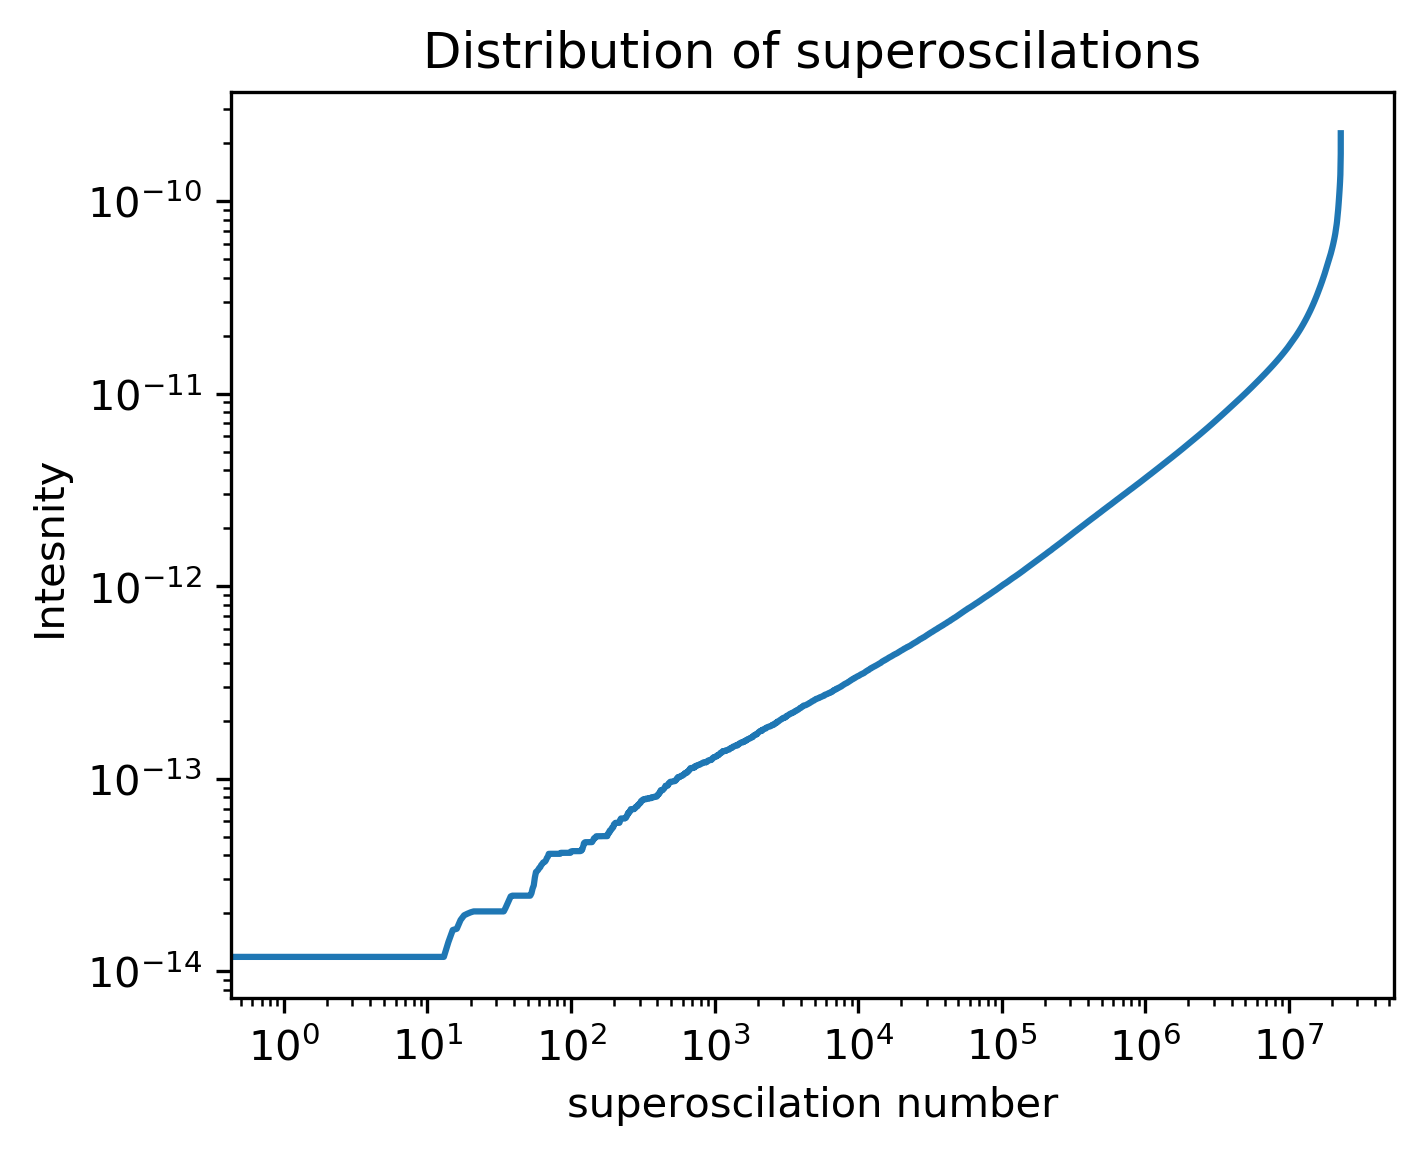

In [31]:
plt.figure(figsize=(5,4), dpi=300)
plt.title("Distribution of superoscilations")
plt.loglog(intensity_without_ampl_modulation)
plt.xlabel('superoscilation number')
plt.ylabel('Intesnity')
plt.show()

## plot best superoscilations

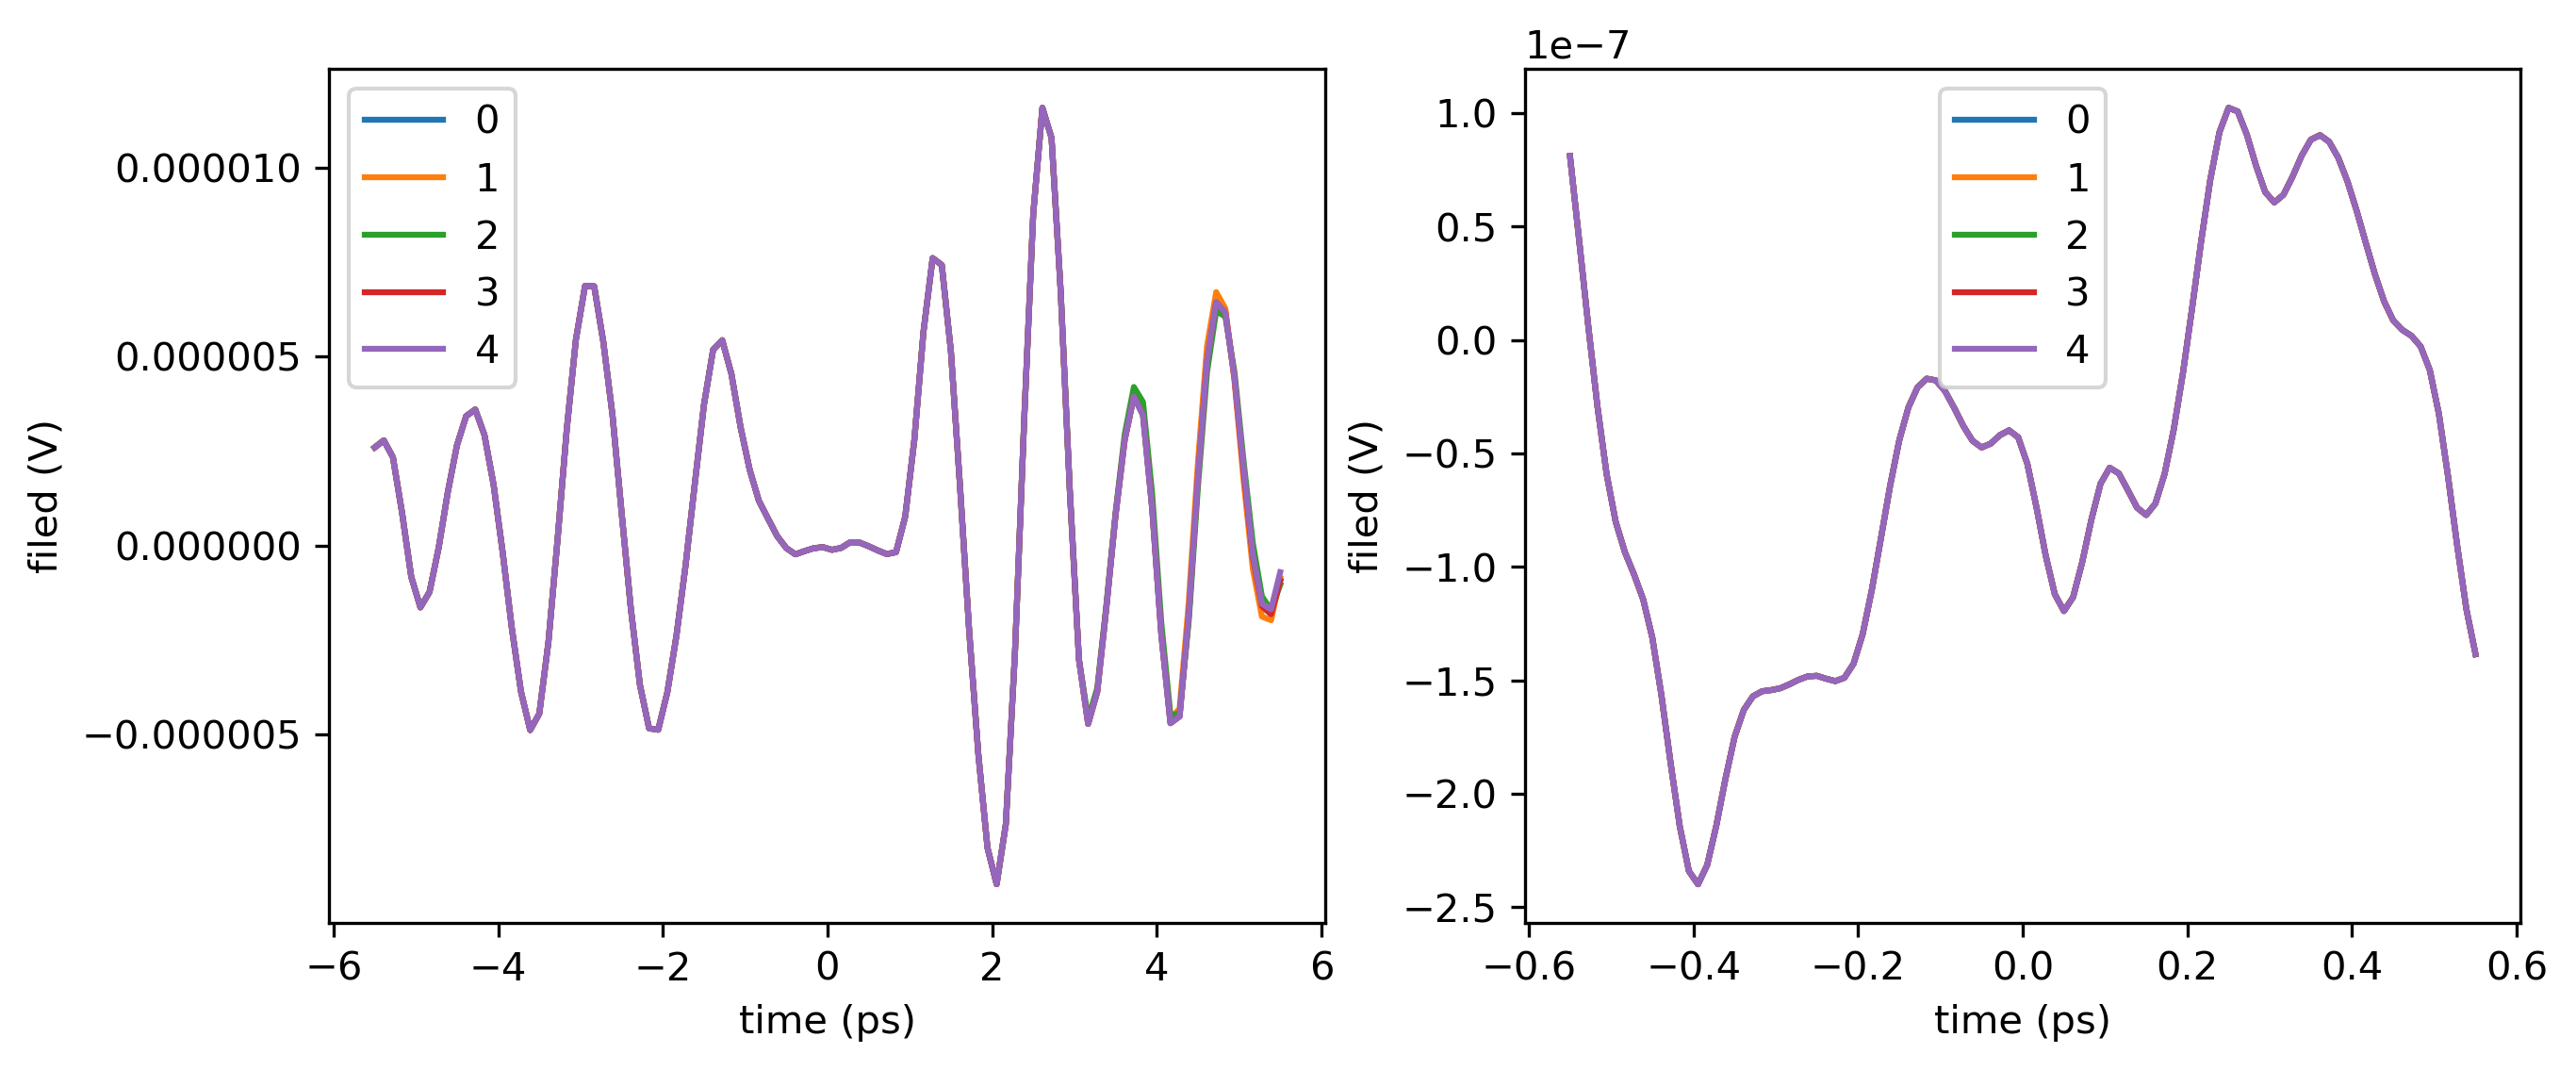

In [21]:
plt.figure(figsize=(10,4), dpi=300)
plt.title("Best superoscilations")

plt.subplot(121)

long_time_window = 10 * time_window

for n, time_delays in enumerate(all_time_delays[:5]):
    plt.plot(long_time_window, get_combined_field(time_delays, long_time_window), label=str(n))
    
plt.xlabel('time (ps)')
plt.ylabel('filed (V)')
plt.legend()

plt.subplot(122)

for n, time_delays in enumerate(all_time_delays[:5]):
    plt.plot(time_window, get_combined_field(time_delays, time_window), label=str(n))
    
plt.xlabel('time (ps)')
plt.ylabel('filed (V)')
plt.legend()


plt.show()  

In [22]:
all_time_delays[:10]

array([[ 12.55, -20.95, -12.55,  16.85,   5.35],
       [ 12.55, -20.95, -12.55,  13.75,   5.35],
       [ 12.55, -20.95, -12.55,  13.15,   5.35],
       [ 12.55, -20.95, -12.55,  16.2 ,   5.35],
       [ 12.55, -20.95, -12.55,  14.95,   5.35],
       [ 12.55, -20.95, -12.55,  11.95,   5.35],
       [ 12.55, -20.95, -12.55,  11.4 ,   5.35],
       [ 12.55, -20.95, -12.55,  14.35,   5.35],
       [ 12.55, -20.95, -12.55,  12.55,   5.35],
       [ 12.55, -20.95, -12.55,  19.3 ,   5.35]])

## Get superoscilationsby using time delays and amplitude modulations 

In [23]:


def inegral_ampl_modulation(time_delays):
    
    # Amplitude variables
    x = cp.Variable(len(pulses))
    constraints = [0 <= x, x <= 1, sum(x) == 1]

    A = [_.interp_field(time_window - delay) for delay, _ in zip(time_delays, pulses.values())]
    A = np.array(A).T
    
    objective = cp.Minimize(cp.sum_squares(A @ x))
    
    
    prob = cp.Problem(objective, constraints)
    intensity = prob.solve()
    
    return intensity, x.value

In [24]:
all_time_delays_ampl_modulation = all_time_delays.copy()

with Pool() as pool:
    intensity_ampl_modulation, ampl_values = zip(
        *pool.map(inegral_ampl_modulation, tqdm(all_time_delays_ampl_modulation))
    )

Extract the best candidates for getting superoscilations  

In [25]:
intensity_ampl_modulation = np.array(intensity_ampl_modulation)

# unlike the time delay permutation objective function, we need to multiply by dt to directly compare two
intensity_ampl_modulation *= time_window[1] - time_window[0]

ampl_values = np.array(ampl_values)
ampl_values = ampl_values[indx]

indx = np.argsort(intensity_ampl_modulation)
intensity_ampl_modulation = intensity_ampl_modulation[indx]

all_time_delays_ampl_modulation = all_time_delays_ampl_modulation[indx]

/home/denys/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


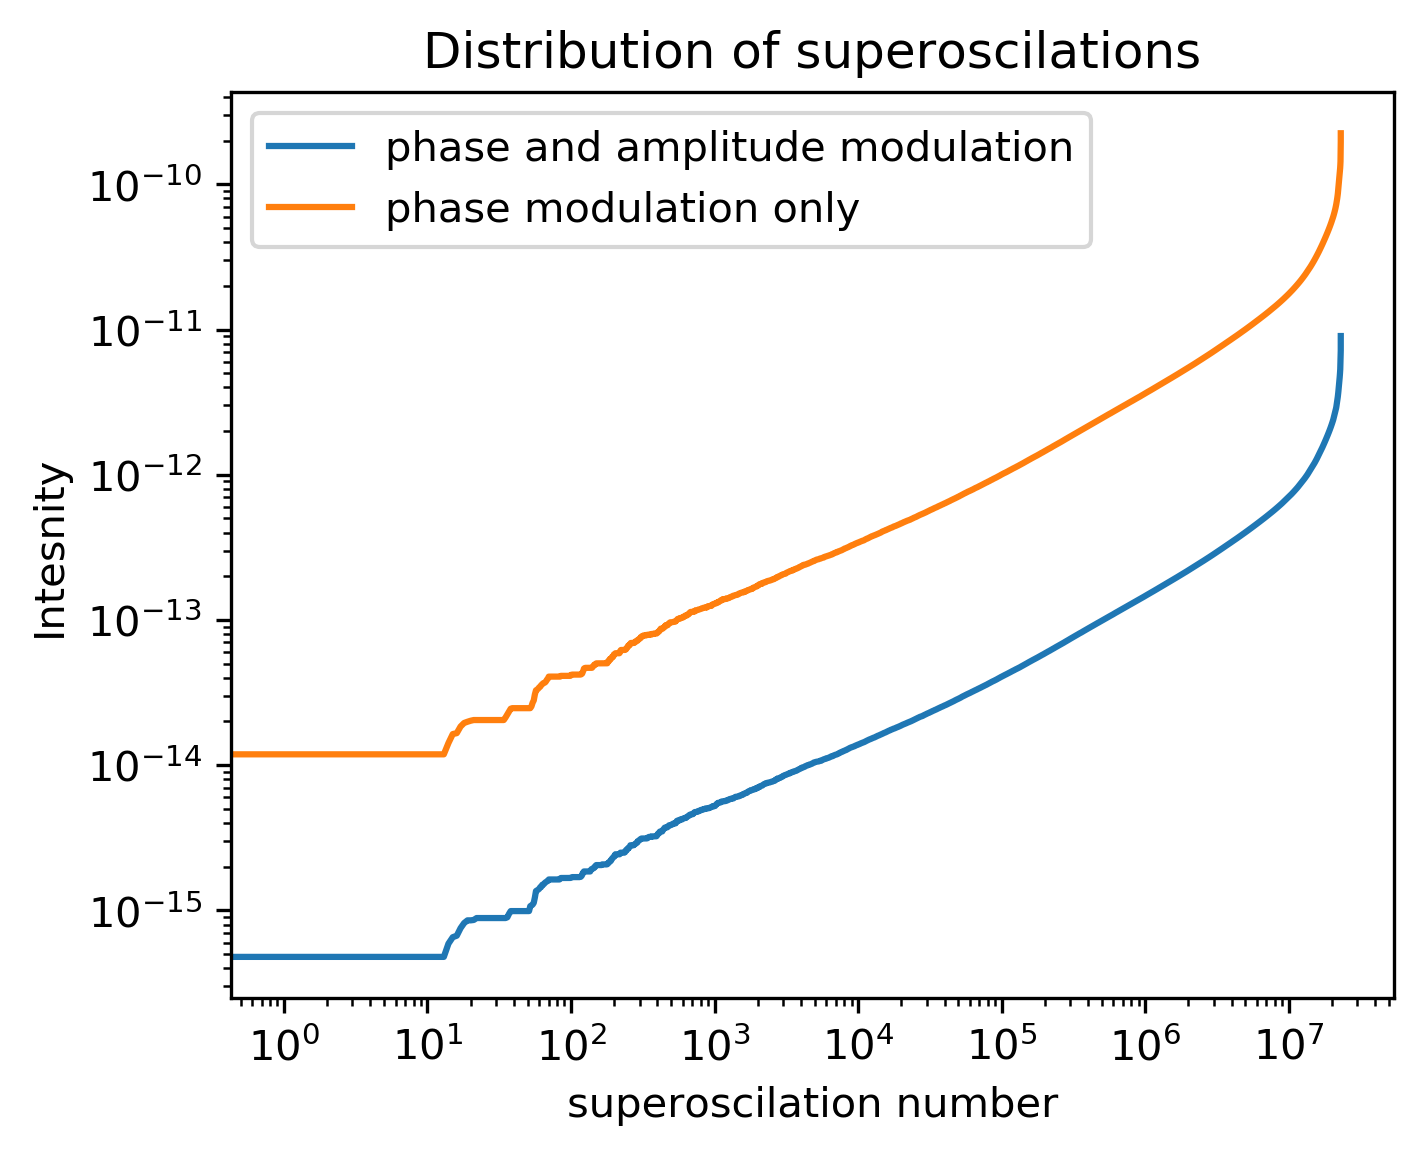

In [32]:
plt.figure(figsize=(5,4), dpi=300)
plt.title("Distribution of superoscilations")
plt.loglog(intensity_ampl_modulation, label="phase and amplitude modulation")
plt.loglog(intensity_without_ampl_modulation, label="phase modulation only")
plt.legend()
plt.xlabel('superoscilation number')
plt.ylabel('Intesnity')
plt.show()

## Is there evidence that amplitude modulation is used (hence, helpful)?

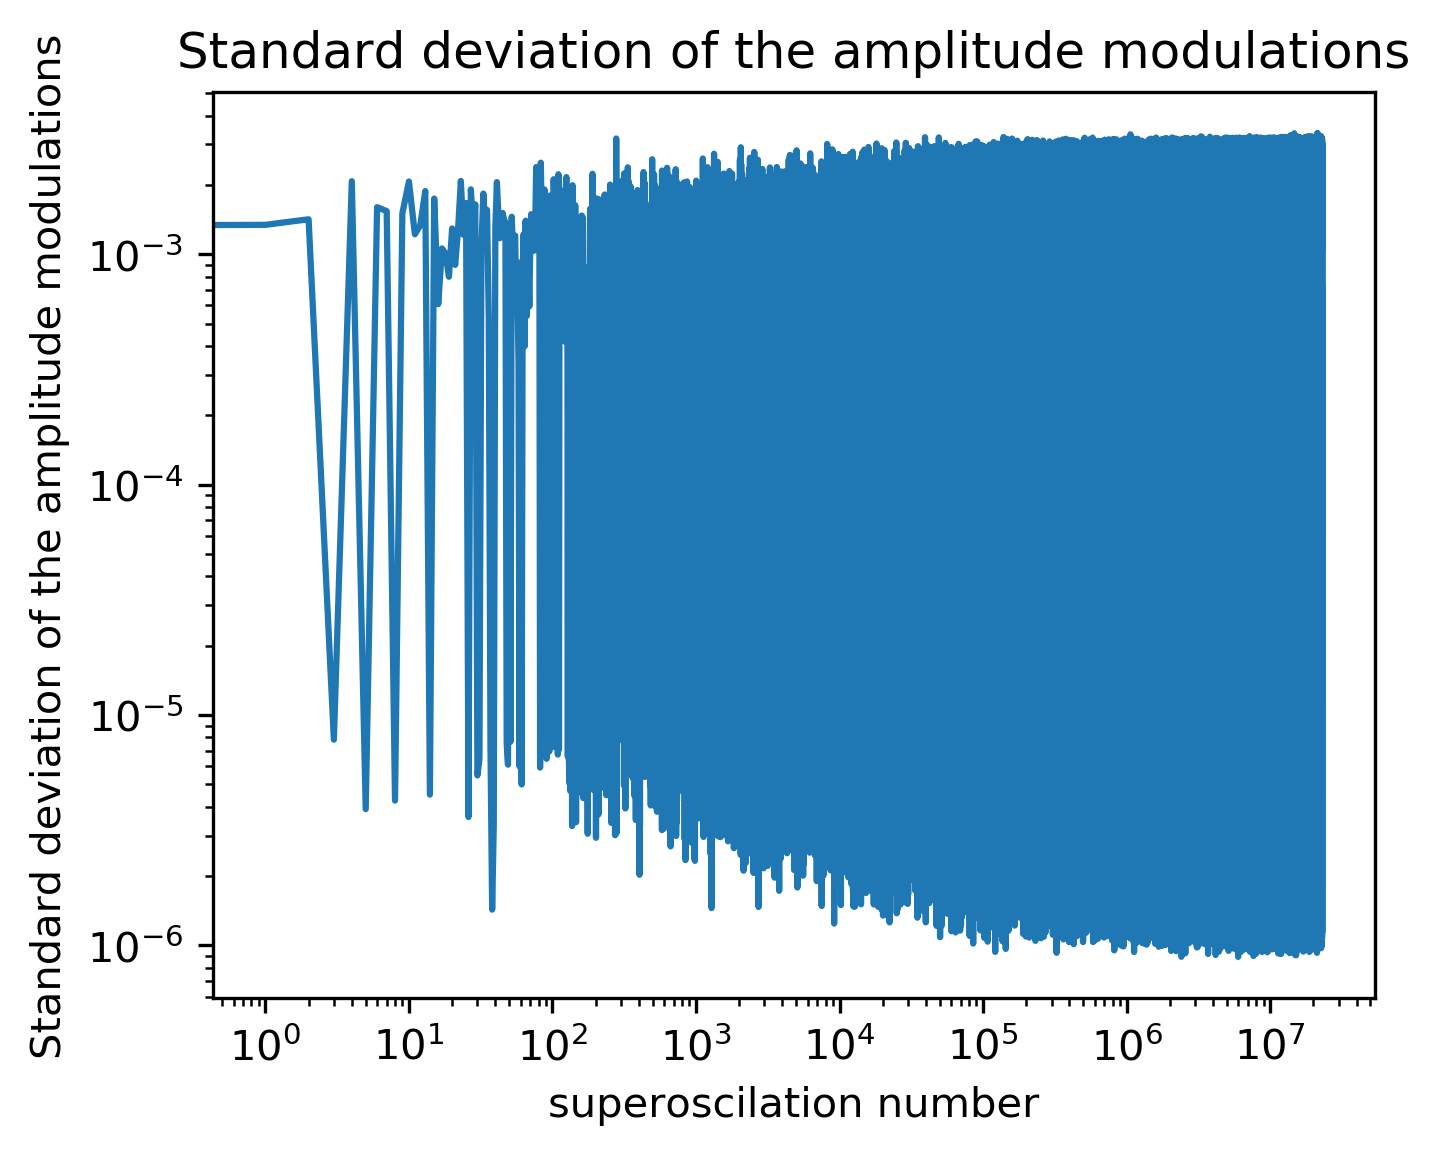

In [27]:
plt.figure(figsize=(5,4), dpi=300)
plt.title("Standard deviation of the amplitude modulations")
plt.loglog(np.std(ampl_values, axis=1))
plt.xlabel('superoscilation number')
plt.ylabel('Standard deviation of the amplitude modulations')
plt.show()

## plot best superoscilations

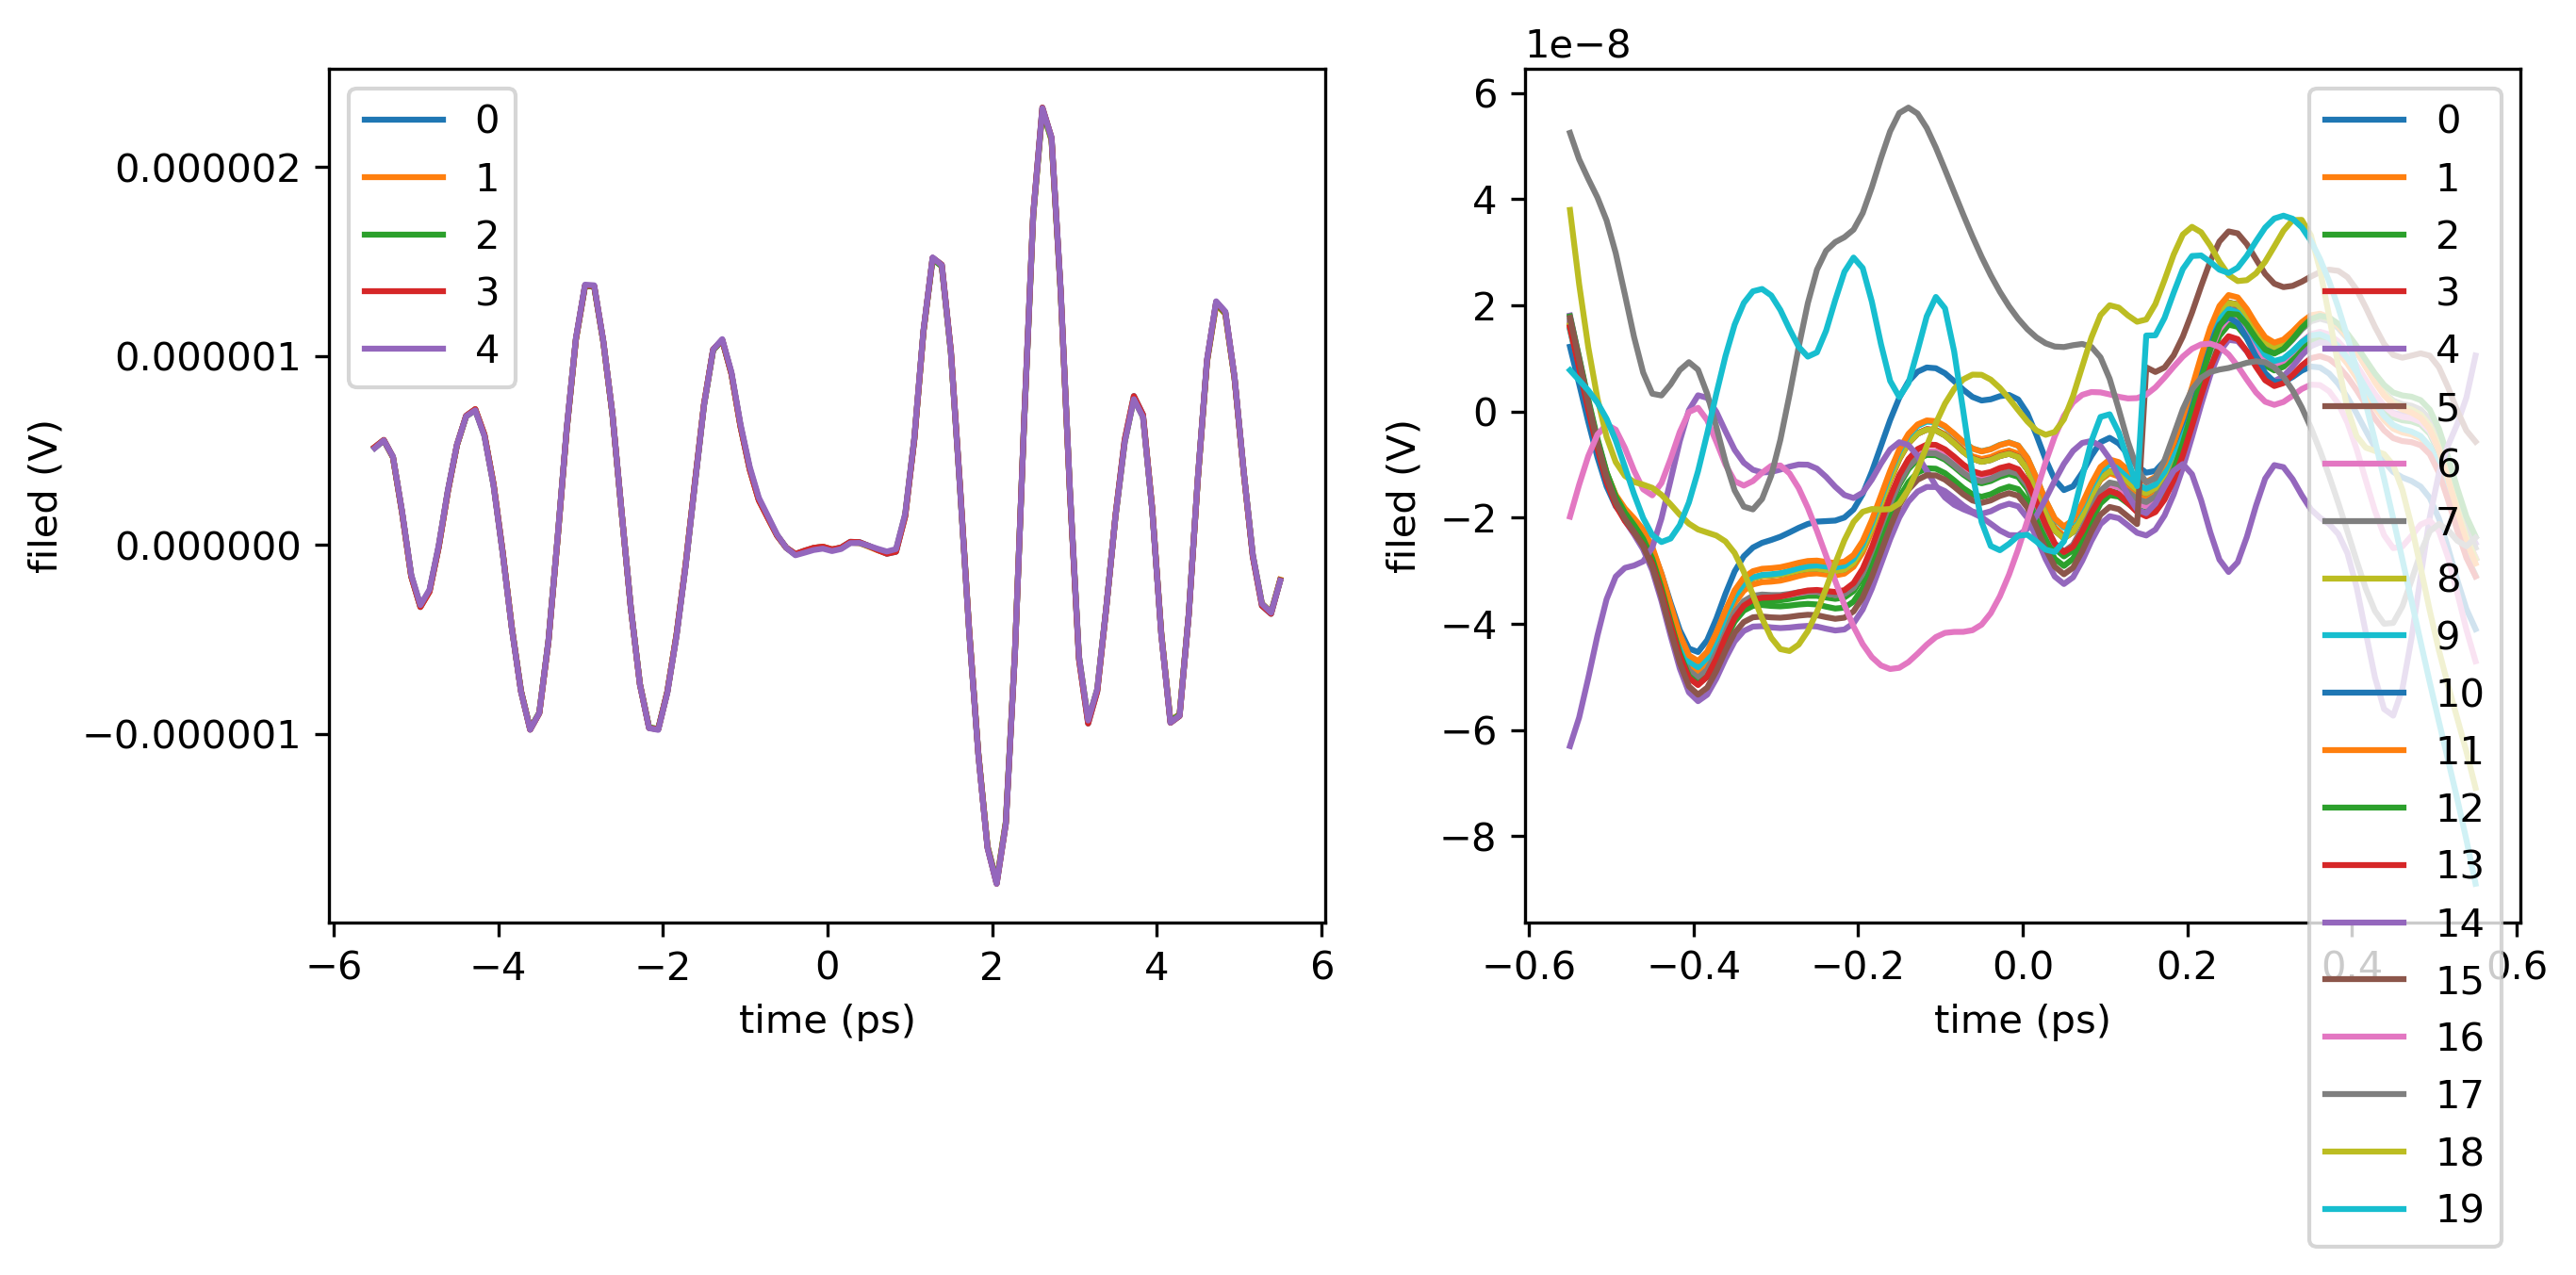

In [28]:
def get_combined_field_ampl_modulation(time_delays, amplitudes, time_window):
    return sum(
        a * _.interp_field(time_window - delay) for delay, a, _ in zip(time_delays, amplitudes, pulses.values())
    )

plt.figure(figsize=(10,4), dpi=300)
plt.title("Best superoscilations with amplitude modulation")

plt.subplot(121)

long_time_window = 10 * time_window

for n, (time_delays, amplitudes) in enumerate(zip(all_time_delays_ampl_modulation[:5], ampl_values[:5])):
    plt.plot(
        long_time_window, 
        get_combined_field_ampl_modulation(time_delays, amplitudes, long_time_window), 
        label=str(n)
    )
    
plt.xlabel('time (ps)')
plt.ylabel('filed (V)')
plt.legend()

plt.subplot(122)

for n, (time_delays, amplitudes) in enumerate(zip(all_time_delays_ampl_modulation[:20], ampl_values[:20])):
    plt.plot(
        time_window, 
        get_combined_field_ampl_modulation(time_delays, amplitudes, time_window), 
        label=str(n)
    )
    
plt.xlabel('time (ps)')
plt.ylabel('filed (V)')
plt.legend()


plt.show()  

In [29]:
all_time_delays_ampl_modulation[:10]

array([[ 12.55, -20.95, -12.55,  16.85,   5.35],
       [ 12.55, -20.95, -12.55,  21.7 ,   5.35],
       [ 12.55, -20.95, -12.55,  15.6 ,   5.35],
       [ 12.55, -20.95, -12.55,  19.95,   5.35],
       [ 12.55, -20.95, -12.55,  19.3 ,   5.35],
       [ 12.55, -20.95, -12.55,  12.55,   5.35],
       [ 12.55, -20.95, -12.55,  14.35,   5.35],
       [ 12.55, -20.95, -12.55,  21.1 ,   5.35],
       [ 12.55, -20.95, -12.55,  11.95,   5.35],
       [ 12.55, -20.95, -12.55,  14.95,   5.35]])

In [30]:
ampl_values[:20]

array([[0.19999536, 0.20000397, 0.19999662, 0.19999478, 0.20000929],
       [0.19986619, 0.20117035, 0.19963302, 0.20157279, 0.19775765],
       [0.20056069, 0.20113757, 0.1989215 , 0.20157697, 0.19780327],
       [0.19999794, 0.20000225, 0.20001357, 0.19999016, 0.19999609],
       [0.2028506 , 0.20195131, 0.19930819, 0.19734067, 0.19854923],
       [0.20000165, 0.20000609, 0.20000074, 0.19999571, 0.19999582],
       [0.20004981, 0.20171768, 0.19872487, 0.20177231, 0.19773533],
       [0.19972397, 0.20197535, 0.19846207, 0.20158001, 0.1982586 ],
       [0.2000045 , 0.20000584, 0.19999646, 0.19999612, 0.19999709],
       [0.19922857, 0.20182514, 0.19955894, 0.20157304, 0.1978143 ],
       [0.20009866, 0.20126036, 0.20303472, 0.19709724, 0.19850902],
       [0.19874182, 0.2012997 , 0.19936746, 0.20164203, 0.19894898],
       [0.20035946, 0.20117147, 0.19821891, 0.20158329, 0.19866687],
       [0.20218889, 0.20129426, 0.20086061, 0.19708901, 0.19856723],
       [0.19999929, 0.20000048, 0.